[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/porterjenkins/byu-cs474/blob/master/lab4_unets.ipynb)

# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research

## Deliverable
For this lab, you will turn in a notebook that describes your efforts at creating
a pytorch radiologist. Your final deliverable is a notebook that has (1) a deep network,
(2) method of calculating accuracy,
(3) images that show the dense prediction produced by your network on the pos_test_000072.png image (index 172 in the validation dataset).
This is an image in the test set that your network will not have seen before.
This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

<img src="https://github.com/wingated/cs474_labs/blob/master/images/pos_test_000072.png?raw=true" width="200">


## Grading standards
Your notebook will be graded on the following:
* 40% Proper design, creation and debugging of a dense prediction network
* 20% Proper implementation of train/test set accuracy measure
* 20% Tidy visualizations of loss of your dense predictor during training
* 20% Test image output


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory)
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all
(files starting with ```pos_``` have some cancerous pixels, while files
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w)
For this lab, you will implement a virtual radiologist.
You are given images of possibly cancerous tissue samples,
and you must build a detector that identifies where in the tissue cancer may reside.

---

### Part 0
Watch and follow video tutorial:

https://youtu.be/Ms19kgK_D8w

**TODO:**

* Watch tutorial

**DONE:**

### Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an
entire image as a single class. Here, however, we are interested in a more nuanced classification:
given an input image, we would like to identify each pixel that is possibly cancerous.
That means that instead of a single output, your network should output an “image”,
where each output pixel of your network represents the probability that a pixel is cancerous.

___

Implement your network topology

Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf)

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d``` and ```nn.CrossEntropyLoss```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.

You can simplify the implementation of this lab by padding the feature maps as they pass through each convolution. This will make the concatenation process easier, though this is technically a departure from the cropping technique outlined in the orginal U-Net paper.

Note that the simplest network you could implement (with all the desired properties)
is just a single convolution layer with two filters and no relu!
Why is that? (of course it wouldn't work very well!)

**TODO:**

* Understand the U-Net architecture
* Understand concatenation of inputs from multiple prior layers
* Understand ConvTranspose
* Answer Question / Reflect on simplest network with the desired properties

**DONE:**


___
The intention of this lab is to learn how to make deep neural nets. We'll help you with the implementation of Dataset.
This code will download the dataset for you so that you are ready to use it and focus on network
implementation, losses and accuracies.

In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
import time
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime.

In [2]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))

    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)

  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]

  def __len__(self):
    return len(self.dataset_folder)

In [ ]:
# You'll probably want a function or something to test input / output sizes of the ConvTranspose2d layer
B = 20   # Chose a random batch size
conv_layer = nn.Conv2d(in_channels=3, out_channels=64,
                       kernel_size=3, padding=0, stride=1)
conv_transpose_layer = nn.ConvTranspose2d(in_channels=3, out_channels=6,
                       kernel_size=2, padding=0, stride=2)
def conv_prac():
    random_tensor = torch.rand((B, 3, 572, 572))
    outpute_tensor = conv_layer(random_tensor)
    print(outpute_tensor.shape)
def conv_transpose_prac():
    random_tensor = torch.rand((B, 3, 8, 8))
    outpute_tensor = conv_transpose_layer(random_tensor)
    print(outpute_tensor.shape)

conv_prac()
conv_transpose_prac()


torch.Size([20, 64, 570, 570])
torch.Size([20, 6, 16, 16])


In [6]:
# Since you will be using the output of one network in two places (convolution and maxpooling),
# you can't use nn.Sequential.
# Instead you will write up the network like normal variable assignment as the example shown below:
# You are welcome (and encouraged) to use the built-in batch normalization and dropout layer.

class CancerDetection(nn.Module):
  def __init__(self): # CancerDetection constructor
    super(CancerDetection, self).__init__()

    # Pooling and activation
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.relu = nn.ReLU(inplace=False)
    self.sigmoid = nn.Sigmoid()

    # Top left part of U-Net
    self.conv11 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # We pad to maintain the dimension (which differs from U-Nets)
    self.conv12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    # Next part
    self.conv21 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.conv22 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    # Next part
    self.conv31 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.conv32 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    # Next part
    self.conv41 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
    self.conv42 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
    # Bottom part
    self.conv51 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
    self.conv52 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)
    # Up 1
    self.upconv6 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
    self.conv61 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1)
    self.conv62 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
    # Up 2
    self.upconv7 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
    self.conv71 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
    self.conv72 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    # Up 3
    self.upconv8 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
    self.conv81 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
    self.conv82 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    # Up 4 (back to top)
    self.upconv9 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
    self.conv91 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
    self.conv92 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.end = nn.Conv2d(64, 2, kernel_size=1, stride=1, padding=0)

  def forward(self, input): # nn.Module sets up a hook that calls forward when you "call" the module object: net(x) calls net.forward(x)
    # Top left
    output1 = self.conv11(input)
    output1 = self.relu(output1)
    output1 = self.conv12(output1)
    output1 = self.relu(output1)
    # Next one
    output2 = self.pool(output1)
    output2 = self.conv21(output2)
    output2 = self.relu(output2)
    output2 = self.conv22(output2)
    output2 = self.relu(output2)
    # Next one
    output3 = self.pool(output2)
    output3 = self.conv31(output3)
    output3 = self.relu(output3)
    output3 = self.conv32(output3)
    output3 = self.relu(output3)
    # Next one
    output4 = self.pool(output3)
    output4 = self.conv41(output4)
    output4 = self.relu(output4)
    output4 = self.conv42(output4)
    output4 = self.relu(output4)
    # Bottom part
    output5 = self.pool(output4)
    output5 = self.conv51(output5)
    output5 = self.relu(output5)
    output5 = self.conv52(output5)
    output5 = self.relu(output5)
    # Up 1
    output6 = self.upconv6(output5)
    output6 = torch.cat((output4, output6), dim=-3)
    output6 = self.conv61(output6)
    output6 = self.relu(output6)
    output6 = self.conv62(output6)
    output6 = self.relu(output6)
    # Up 2
    output7 = self.upconv7(output6)
    output7 = torch.cat((output3, output7), dim=-3)
    output7 = self.conv71(output7)
    output7 = self.relu(output7)
    output7 = self.conv72(output7)
    output7 = self.relu(output7)
    # Up 3
    output8 = self.upconv8(output7)
    output8 = torch.cat((output2, output8), dim=-3)
    output8 = self.conv81(output8)
    output8 = self.relu(output8)
    output8 = self.conv82(output8)
    output8 = self.relu(output8)
    # Up 4 (top)
    output9 = self.upconv9(output8)
    output9 = torch.cat((output1, output9), dim=-3)
    output9 = self.conv91(output9)
    output9 = self.relu(output9)
    output9 = self.conv92(output9)
    output9 = self.relu(output9)
    final_output = self.end(output9)

    return final_output



In [ ]:
output4 = torch.rand((2, 512, 512))
output6 = torch.rand((2, 512, 512))

print(torch.cat((output4, output6), dim=-2).shape)

torch.Size([2, 1024, 512])


In [3]:
# Create your datasets, dataloaders and neural network as you have before
gc.collect()  # Collect garbage
train_dataset = CancerDataset(root="/tmp/", train=True)
val_dataset = CancerDataset(root="/tmp/", train=False)
# Tip: Pass shuffle=True to constructor for training dataloader to automatically shuffle training data each epoch. You can shuffle the validation loader, but you don't need to.


100%|██████████| 2750494655/2750494655 [02:29<00:00, 18356566.84it/s]


Extracting /tmp/cancer_data.tar.gz
Untarring /tmp/cancer_data.tar


In [4]:
def lossFunction(y_hat, y):
  loss = nn.CrossEntropyLoss()
  return loss(y_hat, y)

def get_accuracy(y_hat, y):  # Counts number of pixels guessed correctly
  # If y_hat is within 0.5 of 0 or 1, it gets the correct prediction
  return torch.argmax(y_hat, dim=1).eq(y.long()).sum().item() / y.numel()

In [10]:
# This is what was talked about in the video for memory management

train_losses, val_losses, train_accs, val_accs, times, example_predictions = [], [], [], [], [], []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def scope():
  try:
    #your code for calling dataset and dataloader
    torch.cuda.empty_cache()
    gc.collect()
    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=6, num_workers=4)

    print(torch.cuda.memory_allocated() / 1e9)

    # Call your model, figure out loss and accuracy
    net = CancerDetection().to(device)
    opt = torch.optim.Adam(net.parameters(), lr=.0001)

    # Implement training loop and return the training and validation losses and accuracies.
    net = net.to(device)

    print("Step", "Train Loss", "Train Acc", "Test Loss", "Test Acc", sep="\t")
    start = time.time()
    count = 0

    for epoch in range(1, 6):
      print(f"-----------------------------Epoch {epoch}-----------------------------")
      for x, y in train_loader:
        count += 1
        gc.collect()
        x, y = x.to(device), y.to(device)
        y_hat = net(x)   # Feed through network

        loss = lossFunction(y_hat, y.long())   # Calculate loss and accuracy
        train_losses.append(loss.item())
        with torch.no_grad():
          acc = get_accuracy(y_hat, y)
          train_accs.append(acc)

        loss.backward()   # Gradient descent stuff
        opt.step()
        opt.zero_grad()

        # Validation loss and accuracy
        if count % 50 == 0:
          # Iterate through all batches in validation set
          with torch.no_grad():   # Remove gradient computation to speed up run time
            total_loss, total_acc, total_samples = 0, 0, 0
            for x, y in val_loader:
              x, y = x.to(device), y.to(device)
              y_hat = net(x)
              loss = lossFunction(y_hat, y.long())
              acc = get_accuracy(y_hat, y)

              # Accumulate loss and accuracy, scaled by the batch size
              batch_size = x.size(0)
              total_loss += loss.item() * batch_size
              total_acc += acc * batch_size
              total_samples += batch_size

            val_loss = total_loss / total_samples
            val_acc = total_acc / total_samples
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            print(f"{count}", *("{:.6f}".format(j) for j in (loss, acc, val_loss, val_acc)), sep="\t")

            # Get example image (for part 3)
            example_image = val_dataset[174][0].to(device)
            example_predictions.append(net(example_image))

        times.append(time.time() - start)
        gc.collect()

  except:
    __ITB__()

scope()


0.002097152
Step	Train Loss	Train Acc	Test Loss	Test Acc
-----------------------------Epoch 1-----------------------------
50	0.313698	0.922169	0.357141	0.900896
100	0.372897	0.903183	0.367390	0.901150
150	0.306868	0.879940	0.312138	0.906077
200	0.520592	0.615250	0.235632	0.922848
-----------------------------Epoch 2-----------------------------
250	0.587050	0.543610	0.216373	0.928176
300	0.526039	0.616829	0.239127	0.926933
350	0.595885	0.605568	0.228516	0.927832
400	0.439481	0.696068	0.222484	0.924989
-----------------------------Epoch 3-----------------------------
450	0.453757	0.701546	0.220595	0.924468
500	1.046505	0.415909	0.224492	0.920259
550	0.487511	0.673779	0.224723	0.919724
600	0.314604	0.855289	0.250258	0.917215
650	0.316283	0.853245	0.260111	0.918520
-----------------------------Epoch 4-----------------------------
700	0.503594	0.688759	0.212270	0.924697
750	0.395417	0.781082	0.229748	0.924159
800	0.548548	0.661400	0.213726	0.925817
850	0.586913	0.625141	0.207053	0.923731



___

### Part 2

Plot performance over time

Please generate two plots:

 One that shows loss on the training and validation set as a function of training time.

 One that shows accuracy on the training and validation set as a function of training time.

 Make sure your axes are labeled!

**TODO:**

* Plot training/validation loss as function of training time (not epochs)
* Plot training/validation accuracy as function of training time (not epochs)

**DONE:**



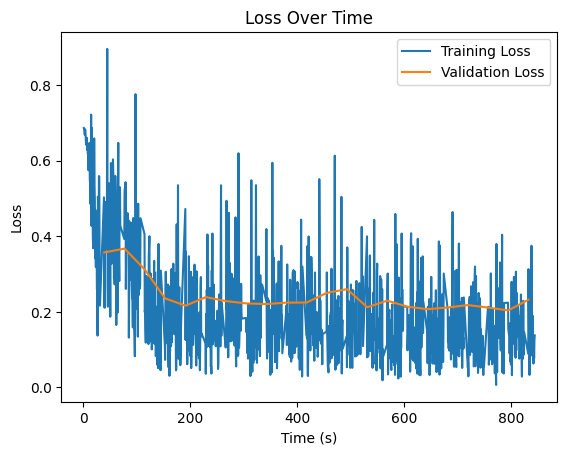

In [12]:
# Your plotting code here
# Loss plot
plt.title("Loss Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Loss")
plt.plot(times, train_losses, label="Training Loss")
plt.plot(times[::50][1:], val_losses, label="Validation Loss")
plt.legend()
plt.show()

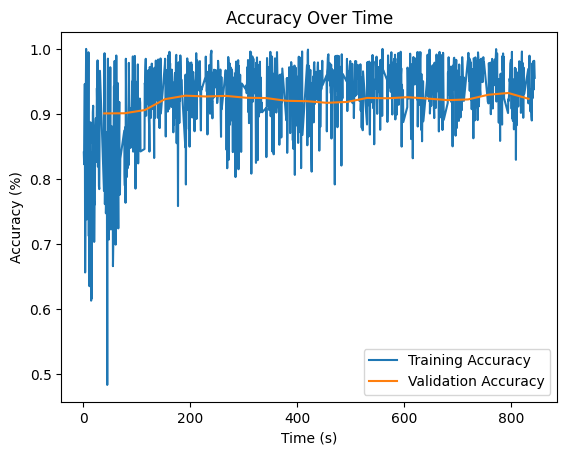

In [14]:
# Accuracy plot
plt.title("Accuracy Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy (%)")
plt.plot(times, train_accs, label="Training Accuracy")
plt.plot(times[::50][1:], val_accs, label="Validation Accuracy")
plt.legend()
plt.show()

**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.
Your trained network should be able to do better than that (but you will not be graded on accuracy).
This is the result I got after 1 hour or training.

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=d23e0b&media=cs501r_f2016:training_accuracy.png)
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=bb8e3c&media=cs501r_f2016:training_loss.png)

As you can see from my graphs above, the model does perform better than 85%. But, it ends up cappint off at around 92-93% (meaning that most of my training at the end wasn't necessary).

___

### Part 3

Generate at least 5 predictions on the pos_test_000072.png image and display them as images. These predictions should be made at a reasonable interval (e.g. every epoch).

You can load this image from the file pos_test_000072.png, or you can get it from the dataset object. It is item 172 of the validation dataset.
You can print both the data instance (x) and the ground-truth label (y_hat) to see how well your network predicts on that instance.

To do this, calculate the output of your trained network on the pos_test_000072.png image,
then make a hard decision (cancerous/not-cancerous) for each pixel.
The resulting image should be black-and-white, where white pixels represent areas
the network considers cancerous.

**DONE:**



The plots of the predictions and ground truth values are below. As we can see, the output of the model changes through training. It seems to look more and more like the true value. But, it still is not as good as we would like it to be.

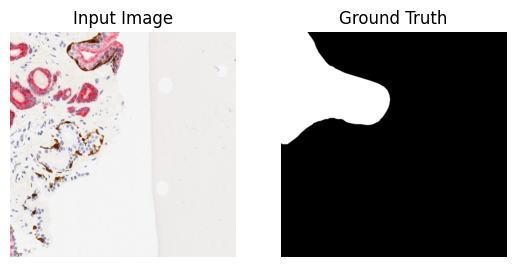

In [21]:
test_image, test_label = val_dataset[172]
test_image = test_image.permute(1, 2, 0)

plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Input Image")
plt.imshow(test_image)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Ground Truth")
plt.imshow(test_label, cmap="gray")
plt.show()

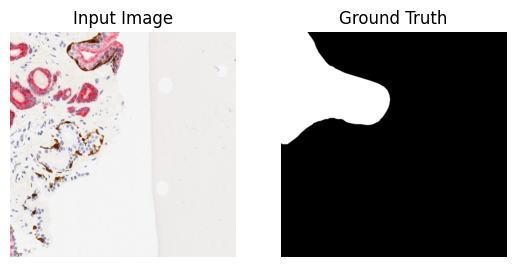

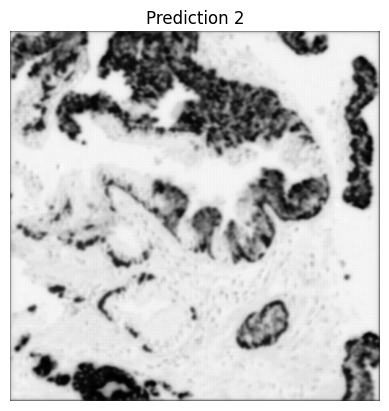

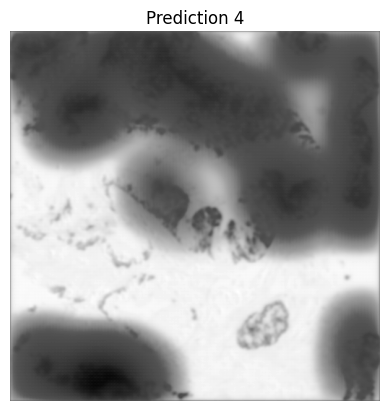

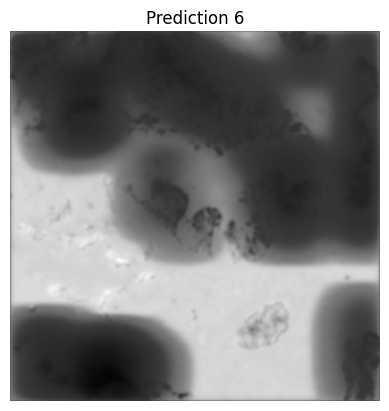

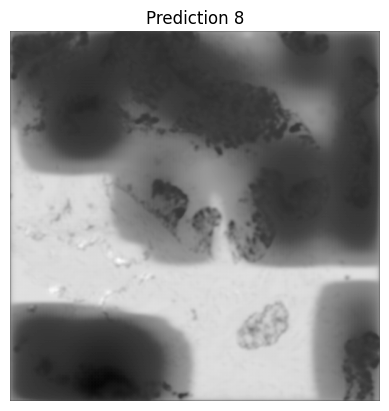

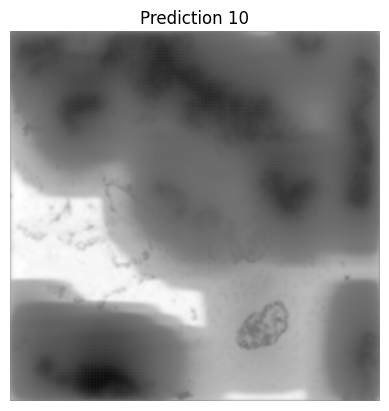

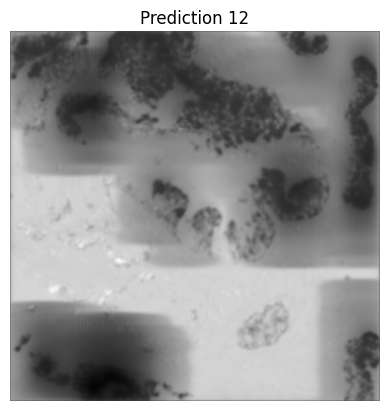

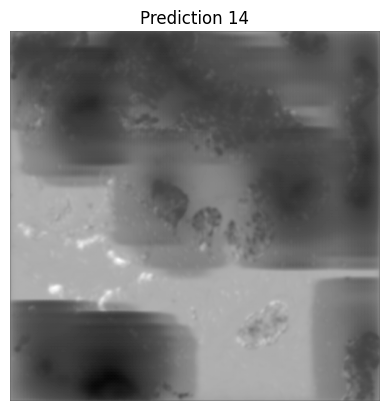

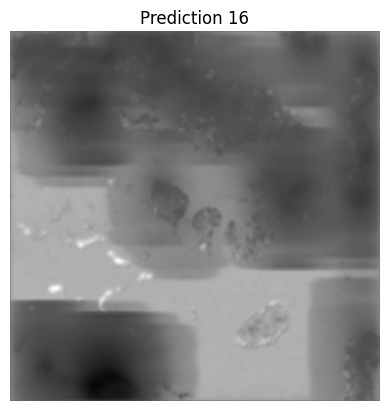

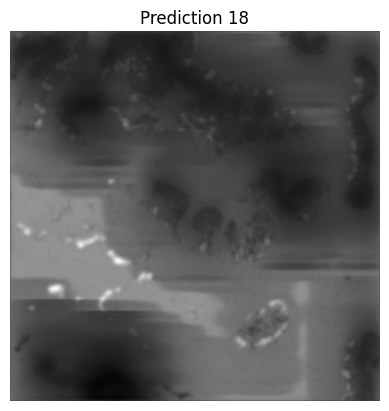

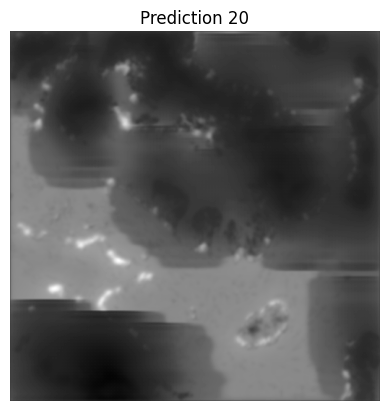

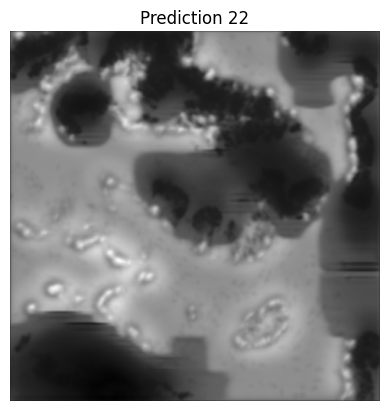

In [24]:
# Code for testing prediction on an image
test_image, test_label = val_dataset[172]
test_image = test_image.permute(1, 2, 0)

plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Input Image")
plt.imshow(test_image)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Ground Truth")
plt.imshow(test_label, cmap="gray")
plt.show()

# Print examples of the predictions for image 172
i = 1
for prediction in example_predictions:
  if i % 2 == 0:
    plt.axis("off")
    plt.title(f"Prediction {i}")
    plt.imshow(prediction.cpu().detach().numpy()[0], cmap="gray")
    plt.show()
  i += 1